In [16]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC, LinearSVC

df_train = pd.read_csv("data/smoker_train.csv")
df_train = df_train.drop_duplicates()

# Allgemeine Analyse

In [17]:
df_train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33467 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  33467 non-null  int64  
 1   height(cm)           33467 non-null  int64  
 2   weight(kg)           33467 non-null  int64  
 3   waist(cm)            33467 non-null  float64
 4   eyesight(left)       33467 non-null  float64
 5   eyesight(right)      33467 non-null  float64
 6   hearing(left)        33467 non-null  int64  
 7   hearing(right)       33467 non-null  int64  
 8   systolic             33467 non-null  int64  
 9   relaxation           33467 non-null  int64  
 10  fasting blood sugar  33467 non-null  int64  
 11  Cholesterol          33467 non-null  int64  
 12  triglyceride         33467 non-null  int64  
 13  HDL                  33467 non-null  int64  
 14  LDL                  33467 non-null  int64  
 15  hemoglobin           33467 non-null  floa

## Cross Correlation

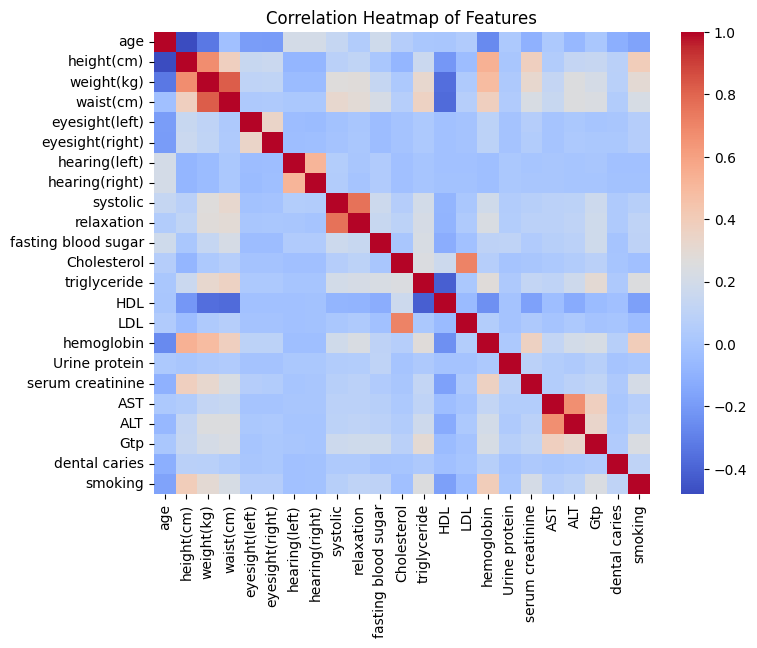

In [19]:
correlation_matrix = df_train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

## Class Imbalance

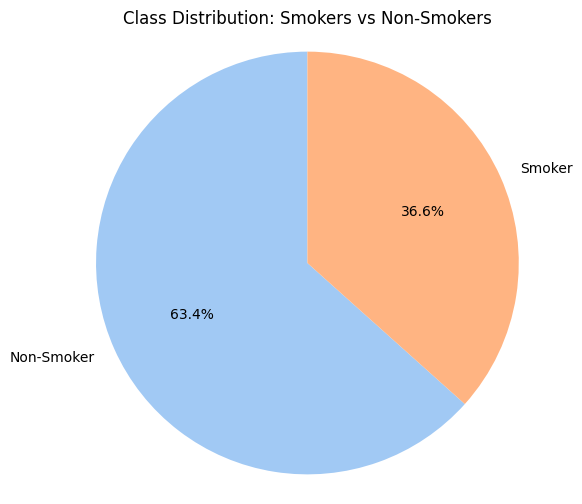

In [20]:
smoking_counts = df_train['smoking'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(smoking_counts, labels=['Non-Smoker', 'Smoker'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Class Distribution: Smokers vs Non-Smokers')
plt.axis('equal')
plt.show()

# Machine Learning Modelle

In [21]:
# store test error and train error for each model
# [model, test_mse, train_mse, test_accuracy, train_accuracy, test_f1, train_f1]
model_errors = []

## Naives Modell

In [22]:
# Modell, das immer "Non-Smoker" (0) vorhersagt
y_true = df_train['smoking']
y_pred_naive = np.zeros_like(y_true)

# Fehlerwerte berechnen
accuracy = accuracy_score(y_true, y_pred_naive)
f1 = f1_score(y_true, y_pred_naive)
mse = mean_squared_error(y_true, y_pred_naive)

print(f"Accuracy (immer Non-Smoker): {accuracy:.4f}")
print(f"F1-Score (immer Non-Smoker): {f1:.4f}")
print(f"Mean Squared Error (immer Non-Smoker): {mse:.4f}")


model_errors.append(['Naive Model', mse, mse, accuracy, accuracy, f1, f1])

Accuracy (immer Non-Smoker): 0.6337
F1-Score (immer Non-Smoker): 0.0000
Mean Squared Error (immer Non-Smoker): 0.3663


## Linear Regression

In [23]:
# Use all columns except 'weight(kg)' and smoking as features
X = df_train[['height(cm)', 'waist(cm)', 'age', 'hemoglobin']]
y = df_train['weight(kg)']

# Split data into training and testing sets (using only training set for comparison)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Training der Modelle
lr_model = LinearRegression().fit(X_train_1, y_train_1)

y_pred = lr_model.predict(X_test_1)

print(f"Intercept: {lr_model.intercept_}")
for name, coef in zip(X.columns, lr_model.coef_):
    print(f"Coefficient for {name}: {coef}")

mse = mean_squared_error(y_test_1, y_pred)
print(f"Test Mean Squared Error: {mse}")

Intercept: -85.67393785255585
Coefficient for height(cm): 0.48268470000487823
Coefficient for waist(cm): 0.9516671200832515
Coefficient for age: -0.14866804586351912
Coefficient for hemoglobin: 0.04087488707372785
Test Mean Squared Error: 24.512838569931095


## Decision Tree limited leaves

In [24]:
X = df_train[['height(cm)', 'waist(cm)', 'hemoglobin']]
y = df_train['smoking']

# Split data into training and testing sets (using only training set for comparison)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Training der Modelle
dtc = DecisionTreeClassifier(random_state=0, max_leaf_nodes=7).fit(X_train_1, y_train_1)

y_pred_train = dtc.predict(X_train)
y_pred = dtc.predict(X_test)


print('Accuracy of Decision Tree-Train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_pred, y_test))

model_errors.append(['Decision Tree', 0, 0, accuracy_score(y_pred, y_test), accuracy_score(y_pred_train, y_train), f1_score(y_test, y_pred), f1_score(y_train, y_pred_train)])

Accuracy of Decision Tree-Train:  0.6896126694804467
Accuracy of Decision Tree-Test:  0.695697639677323


[Text(0.5555555555555556, 0.9, 'x[0] <= 162.5\ngini = 0.463\nsamples = 21418\nvalue = [13635, 7783]'),
 Text(0.3333333333333333, 0.7, 'x[2] <= 15.05\ngini = 0.227\nsamples = 8633\nvalue = [7504, 1129]'),
 Text(0.4444444444444444, 0.8, 'True  '),
 Text(0.2222222222222222, 0.5, 'x[2] <= 13.95\ngini = 0.148\nsamples = 7460\nvalue = [6859, 601]'),
 Text(0.1111111111111111, 0.3, 'gini = 0.099\nsamples = 5414\nvalue = [5132, 282]'),
 Text(0.3333333333333333, 0.3, 'x[0] <= 157.5\ngini = 0.263\nsamples = 2046\nvalue = [1727, 319]'),
 Text(0.2222222222222222, 0.1, 'gini = 0.143\nsamples = 1161\nvalue = [1071, 90]'),
 Text(0.4444444444444444, 0.1, 'gini = 0.384\nsamples = 885\nvalue = [656, 229]'),
 Text(0.4444444444444444, 0.5, 'gini = 0.495\nsamples = 1173\nvalue = [645, 528]'),
 Text(0.7777777777777778, 0.7, 'x[2] <= 13.75\ngini = 0.499\nsamples = 12785\nvalue = [6131.0, 6654.0]'),
 Text(0.6666666666666667, 0.8, '  False'),
 Text(0.6666666666666666, 0.5, 'x[0] <= 167.5\ngini = 0.367\nsamples 

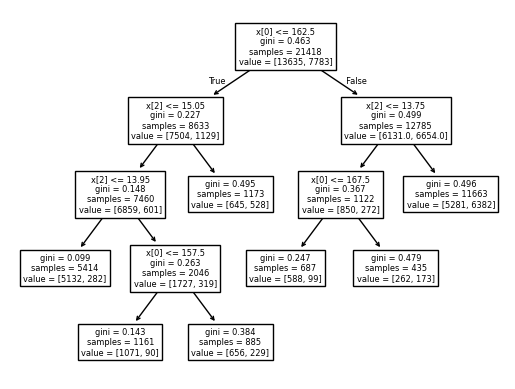

In [25]:
plot_tree(dtc)

## Decision Tree limited depth

In [26]:

# Input Variablen
X = df_train.drop('smoking', axis=1)
# Output Variable
y = df_train['smoking']

# Test und Trainingssplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# array100 = list(range(1, 20))
# for depth in array100:
#     # Decision Tree Classifier
#     dtc = DecisionTreeClassifier(random_state=0, max_depth=depth).fit(X_train, y_train)
    
#     # Modellanwendung
#     y_pred_train = dtc.predict(X_train)
#     y_pred = dtc.predict(X_test)
    
#     print(f'Depth: {depth}')
#     print('Accuracy of Decision Tree-Train: ', accuracy_score(y_pred_train, y_train))
#     print('Accuracy of Decision Tree-Test: ', accuracy_score(y_pred, y_test))
    # Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train, y_train)

# Modellanwendung
y_pred_train = dtc.predict(X_train)
y_pred = dtc.predict(X_test)

print('Accuracy of Decision Tree-Train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Decision Tree-Test: ', accuracy_score(y_pred, y_test))


model_errors.append(['Decision Tree (max_depth=4)', 0, 0, accuracy_score(y_pred, y_test), accuracy_score(y_pred_train, y_train), f1_score(y_test, y_pred), f1_score(y_train, y_pred_train)])


Accuracy of Decision Tree-Train:  0.7265902214918014
Accuracy of Decision Tree-Test:  0.7249775918733193


[Text(0.5, 0.9, 'x[1] <= 162.5\ngini = 0.463\nsamples = 26773\nvalue = [17030, 9743]'),
 Text(0.25, 0.7, 'x[15] <= 15.25\ngini = 0.224\nsamples = 10784\nvalue = [9396.0, 1388.0]'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'x[20] <= 31.5\ngini = 0.154\nsamples = 9575\nvalue = [8769, 806]'),
 Text(0.0625, 0.3, 'x[0] <= 37.5\ngini = 0.105\nsamples = 7690\nvalue = [7264, 426]'),
 Text(0.03125, 0.1, 'gini = 0.465\nsamples = 68\nvalue = [43, 25]'),
 Text(0.09375, 0.1, 'gini = 0.1\nsamples = 7622\nvalue = [7221, 401]'),
 Text(0.1875, 0.3, 'x[1] <= 157.5\ngini = 0.322\nsamples = 1885\nvalue = [1505, 380]'),
 Text(0.15625, 0.1, 'gini = 0.205\nsamples = 1176\nvalue = [1040, 136]'),
 Text(0.21875, 0.1, 'gini = 0.451\nsamples = 709\nvalue = [465.0, 244.0]'),
 Text(0.375, 0.5, 'x[20] <= 36.5\ngini = 0.499\nsamples = 1209\nvalue = [627, 582]'),
 Text(0.3125, 0.3, 'x[1] <= 157.5\ngini = 0.464\nsamples = 609\nvalue = [386, 223]'),
 Text(0.28125, 0.1, 'gini = 0.326\nsamples = 190\nvalue = [151, 3

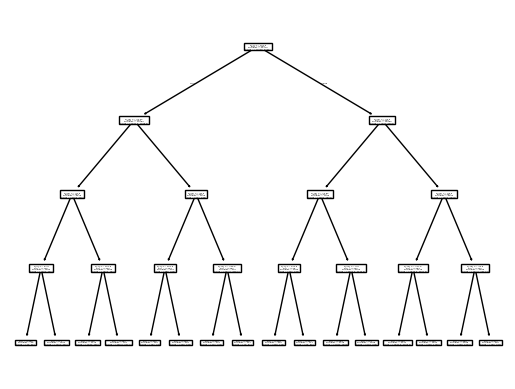

In [27]:
plot_tree(dtc)

Bestes ccp_alpha durch Cross-Validation: 0.0010413348470269396
Genauigkeit des besten Modells auf dem Testdatensatz: 0.7186
Genauigkeit des besten Modells auf dem Testdatensatz (f1): 0.6080
Mean Squared Error des besten Modells auf dem Testdatensatz: 0.2814


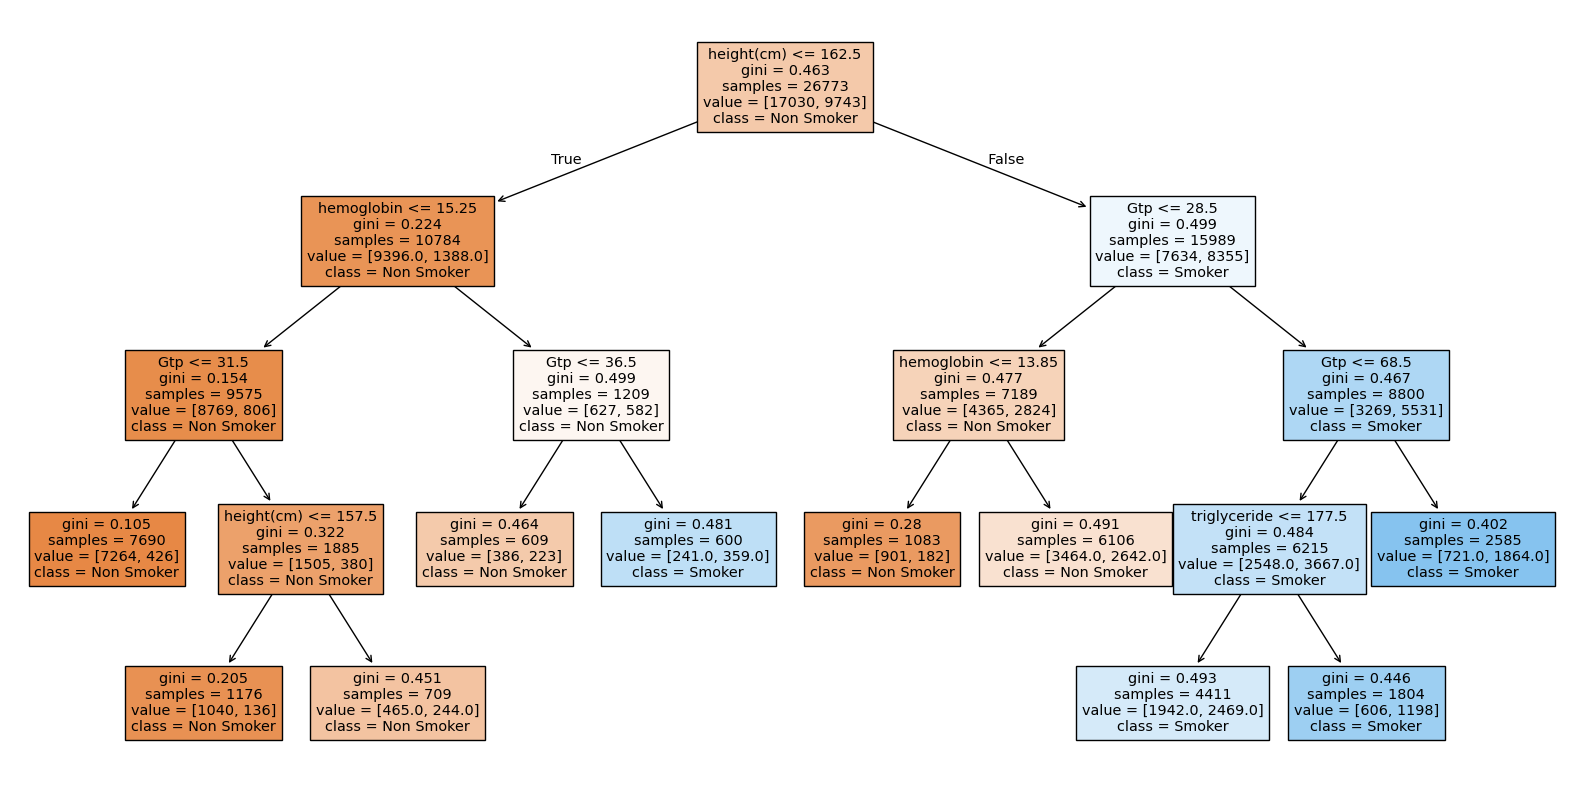

In [28]:

# Input Variablen
X = df_train.drop('smoking', axis=1)
# Output Variable
y = df_train['smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ermittlung aller ccp_alpha-Werte durch den Pruning-Pfad
path = dtc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Verwendung von GridSearchCV zur Bestimmung des besten ccp_alpha-Werts
param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Das beste ccp_alpha ermitteln
best_ccp_alpha = grid_search.best_params_['ccp_alpha']
print(f"Bestes ccp_alpha durch Cross-Validation: {best_ccp_alpha}")

# Modell mit dem besten ccp_alpha trainieren
best_dtc = DecisionTreeClassifier(random_state=42, ccp_alpha=best_ccp_alpha)
best_dtc.fit(X_train, y_train)

# Vorhersagen und Genauigkeit auf den Testdaten
y_pred = best_dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Genauigkeit des besten Modells auf dem Testdatensatz: {accuracy:.4f}")
print(f"Genauigkeit des besten Modells auf dem Testdatensatz (f1): {f1:.4f}")
print(f"Mean Squared Error des besten Modells auf dem Testdatensatz: {mean_squared_error(y_test, y_pred):.4f}")
# Entscheidungsbaum des besten Modells visualisieren
plt.figure(figsize=(20, 10))
plot_tree(best_dtc, filled=True, feature_names=X.columns, class_names=["Non Smoker", "Smoker"])
plt.show()

model_errors.append(['Decision Tree (best ccp_alpha)', 0, 0, accuracy, accuracy_score(y_train, best_dtc.predict(X_train)), f1, f1_score(y_train, best_dtc.predict(X_train))])

## SVC Modelle

In [29]:
# Define features and target variable
X = df_train.drop('smoking', axis=1)
y = df_train['smoking']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVC model
svc_model = SVC(random_state=42)
svc_model.fit(X_train, y_train)

# Make predictions
y_pred = svc_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Genauigkeit des besten Modells auf dem Testdatensatz: {accuracy:.4f}")
print(f"Genauigkeit des besten Modells auf dem Testdatensatz (f1): {f1:.4f}")


model_errors.append(['SVC', 0, 0, accuracy, accuracy_score(y_train, svc_model.predict(X_train)), f1, f1_score(y_train, svc_model.predict(X_train))])

Genauigkeit des besten Modells auf dem Testdatensatz: 0.7153
Genauigkeit des besten Modells auf dem Testdatensatz (f1): 0.5692


In [30]:
# Define features and target variable
X = df_train.drop('smoking', axis=1)
y = df_train['smoking']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVC model
svc_model = LinearSVC(random_state=42)
svc_model.fit(X_train, y_train)

# Make predictions
y_pred = svc_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Genauigkeit des besten Modells auf dem Testdatensatz: {accuracy:.4f}")
print(f"Genauigkeit des besten Modells auf dem Testdatensatz (f1): {f1:.4f}")


model_errors.append(['Linear SVC', 0, 0, accuracy, accuracy_score(y_train, svc_model.predict(X_train)), f1, f1_score(y_train, svc_model.predict(X_train))])

Genauigkeit des besten Modells auf dem Testdatensatz: 0.7108
Genauigkeit des besten Modells auf dem Testdatensatz (f1): 0.5826


In [31]:
# # Define features and target variable
# X = df_train.drop('smoking', axis=1)
# y = df_train['smoking']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# svc=SVC() 



# # declare parameters for hyperparameter tuning
# parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
#                {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
#                {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
#               ]




# grid_search = GridSearchCV(estimator = svc,  
#                            param_grid = parameters,
#                            scoring = 'accuracy',
#                            cv = 5,
#                            verbose=0)


# grid_search.fit(X_train, y_train)

# y_pred = grid_search.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# print(f"Genauigkeit des besten Modells auf dem Testdatensatz: {accuracy:.4f}")
# print(f"Genauigkeit des besten Modells auf dem Testdatensatz (f1): {f1:.4f}")

 

## Model Evaluation

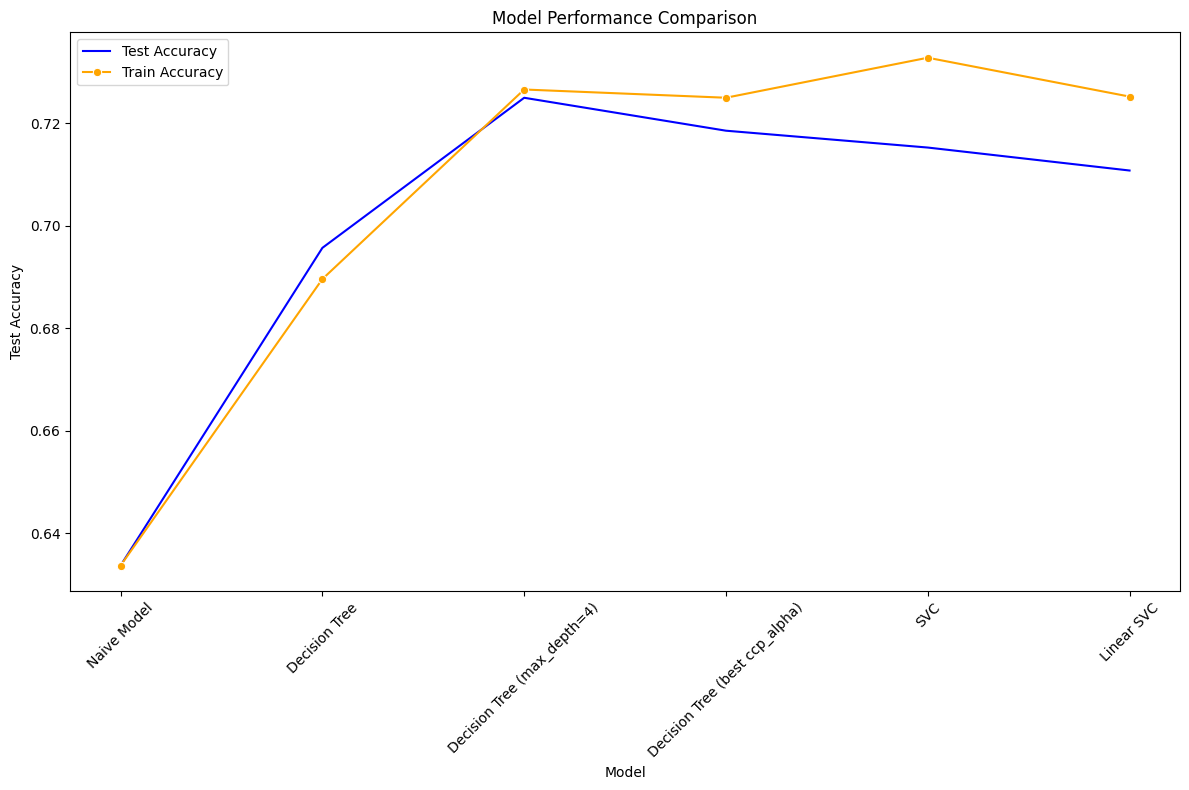

In [33]:
# Visualize model errors
model_errors_df = pd.DataFrame(model_errors, columns=['Model', 'Test MSE', 'Train MSE', 'Test Accuracy', 'Train Accuracy', 'Test F1', 'Train F1'])
plt.figure(figsize=(12, 8))
sns.lineplot(x='Model', y='Test Accuracy', data=model_errors_df, color='blue', label='Test Accuracy')
sns.lineplot(x='Model', y='Train Accuracy', data=model_errors_df, color='orange', label='Train Accuracy', marker='o')
plt.xticks(rotation=45)
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()